# Benchmarks for Pescador

Here we create benchmarks for sampling against npy files with various amounts of data (by shape and number of samples)

In [32]:
import pprint
import tempfile
import numpy as np
import pescador
import time
import os

import matplotlib.pyplot as plt

%matplotlib inline

n_samples = [100, 1000, 5000, 10000, 20000, 25000, 50000]
sample_shapes = [(1, 10), (1, 10, 79), (1, 3, 28, 28), (1, 6, 26, 26)]

n_to_test = 1000
buffer_size = 128

In [33]:
def create_npy(n_samples, sample_shapes, filename):
    shape = list(sample_shapes)
    shape[0] = n_samples
    arrays_to_save = np.random.random(shape)
    
    np.save(filename, arrays_to_save)
    
def npy_gen(filename, mmap='r'):
    data_in = np.load(filename, mmap_mode=mmap)
    
    while True:
        i = np.random.randint(len(data_in))
        yield dict(X=np.array(data_in[i]))

In [34]:
create_times = {}
generator_sample_times = {}
stream_sample_times = {}
batch_sample_times = {}
with tempfile.TemporaryDirectory() as tmpdir:
    for n in n_samples:
        for s in sample_shapes:
            key = (n, s)
            filename = "random_{}_{}.npy".format(n, "-".join([str(x) for x in s]))
            filepath = os.path.join(tmpdir, filename)
            
            # Create the test file
            c0 = time.time()
            create_npy(n, s, filepath)
            create_times[key] = time.time() - c0
            print(filename, "created in", "{}s".format(create_times[key]))
            
            # Sample from it with no streamer
            sample_times = []
            s0 = time.time()
            for i, batch in enumerate(npy_gen(filepath)):
                sample_times.append(time.time() - s0)
                
                if i > n_to_test:
                    break
                s0 = time.time()
            
            generator_sample_times[key] = np.mean(sample_times)
            print(filename, "generator sampling average:", "{:.7f}s".format(generator_sample_times[key]))
            
            # Sample from it with a basic streamer
            streamer = pescador.Streamer(npy_gen(filepath))
            sample_times = []
            s0 = time.time()
            for batch in streamer.generate(max_batches=n_to_test):
                sample_times.append(time.time() - s0)
                s0 = time.time()
                
            stream_sample_times[key] = np.mean(sample_times)
            print(filename, "streamer sampling average:", "{:.7f}s".format(stream_sample_times[key]))
                
            # sample from it with a batch streamer
            buffstream = pescador.BufferedStreamer(streamer, buffer_size)
            sample_times = []
            s0 = time.time()
            for batch in buffstream.generate(max_batches=n_to_test):
                sample_times.append(time.time() - s0)
                s0 = time.time()
                
            batch_sample_times[key] = np.mean(sample_times)
            print(filename, "buffered sampling average:", "{:.7f}s".format(batch_sample_times[key]))
            print(filename, "buffered sampling per sample average:", "{:.7f}s".format(batch_sample_times[key] / buffer_size))

random_100_1-10.npy created in 0.0008039474487304688s
random_100_1-10.npy generator sampling average: 0.0000235s
random_100_1-10.npy streamer sampling average: 0.0000097s
random_100_1-10.npy buffered sampling average: 0.0001313s
random_100_1-10.npy buffered sampling per sample average: 0.0000010s
random_100_1-10-79.npy created in 0.004575967788696289s
random_100_1-10-79.npy generator sampling average: 0.0000304s
random_100_1-10-79.npy streamer sampling average: 0.0000090s
random_100_1-10-79.npy buffered sampling average: 0.0001731s
random_100_1-10-79.npy buffered sampling per sample average: 0.0000014s
random_100_1-3-28-28.npy created in 0.0071849822998046875s
random_100_1-3-28-28.npy generator sampling average: 0.0000315s
random_100_1-3-28-28.npy streamer sampling average: 0.0000124s
random_100_1-3-28-28.npy buffered sampling average: 0.0006787s
random_100_1-3-28-28.npy buffered sampling per sample average: 0.0000053s
random_100_1-6-26-26.npy created in 0.01576709747314453s
random_100

In [ ]:
pprint.pprint(create_times)
pprint.pprint(generator_sample_times)
pprint.pprint(stream_sample_times)
pprint.pprint(batch_sample_times)

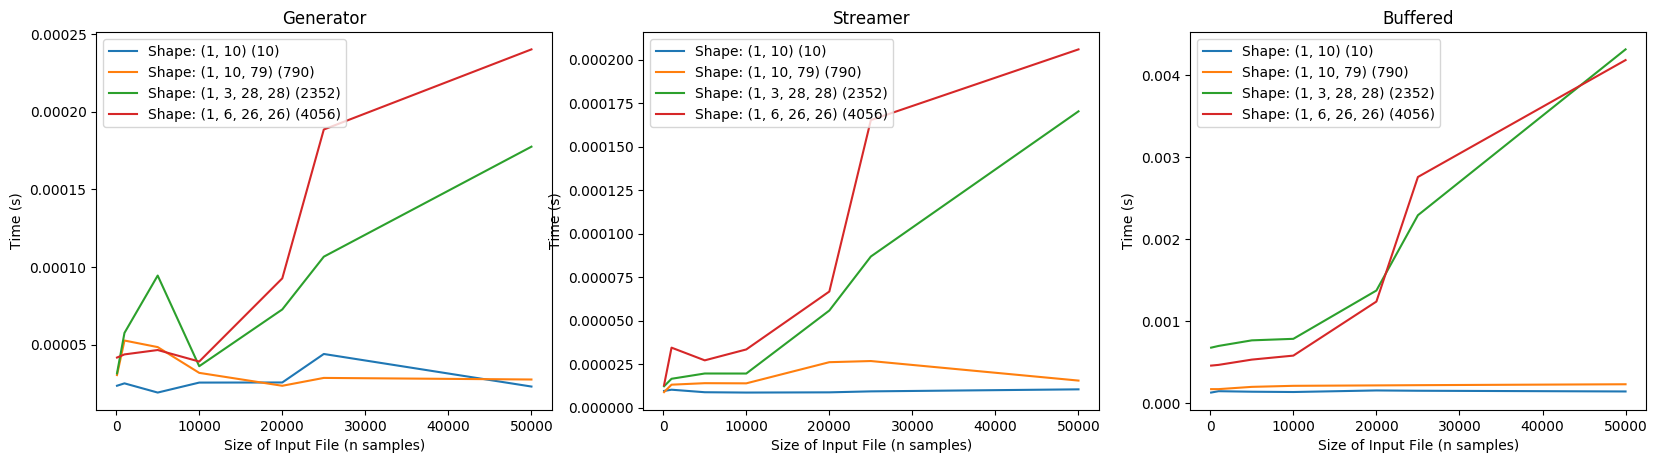

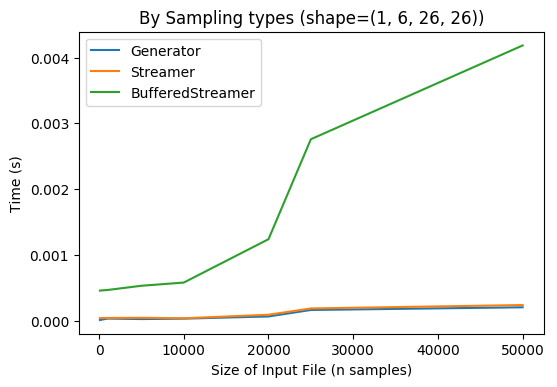

In [59]:
def calc_params(s):
    return np.product(s)

# Generator sampling for increasing Samples
N = [n for n in n_samples]
plt.figure(figsize=(20, 5))
plt.subplot(131)
for s in sample_shapes:
    plt.plot(N, [generator_sample_times[(n, s)] for n in n_samples], label="Shape: {} ({})".format(s, calc_params(s)))
plt.legend()
plt.xlabel('Size of Input File (n samples)')
plt.ylabel('Time (s)')
plt.title("Generator")

# Simple sampling for increasing Samples
plt.subplot(132)
for s in sample_shapes:
    plt.plot(N, [stream_sample_times[(n, s)] for n in n_samples], label="Shape: {} ({})".format(s, calc_params(s)))
plt.legend()
plt.xlabel('Size of Input File (n samples)')
plt.ylabel('Time (s)')
plt.title("Streamer")

# Buffered sampling for increasing Samples
plt.subplot(133)
for s in sample_shapes:
    plt.plot(N, [batch_sample_times[(n, s)] for n in n_samples], label="Shape: {} ({})".format(s, calc_params(s)))
plt.legend()
plt.xlabel('Size of Input File (n samples)')
plt.ylabel('Time (s)')
plt.title("Buffered")


# Constant shape, across types sampling for increasing Samples
S = sample_shapes[-1]
N = [n for n in n_samples]
plt.figure()
plt.plot(N, [stream_sample_times[(n, s)] for n in n_samples], label="Generator")
plt.plot(N, [generator_sample_times[(n, s)] for n in n_samples], label="Streamer")
plt.plot(N, [batch_sample_times[(n, s)] for n in n_samples], label="BufferedStreamer")
plt.legend()
plt.xlabel('Size of Input File (n samples)')
plt.ylabel('Time (s)')
plt.title("By Sampling types (shape={})".format(S))